# <div style="padding:15px; background-color:#26344e; font-family:JetBrains Mono; font-weight:bold; color:#f2f2f0; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Customer Segmentation</div>

In [1]:
import helperfunction as hf
import importlib
importlib.reload(hf)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

In [2]:
invoice_df = hf.create_df('invoice_data')
invoice_df.head()

Current work Directory /Users/shubhamjadhav/My Drive/MS/Coursework/3. Fall 2023/DM/Term Project/Customer-Segmentation/Code
File Path is  /Users/shubhamjadhav/My Drive/MS/Coursework/3. Fall 2023/DM/Term Project/Customer-Segmentation/Code/invoice_data


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# invoice_df = pd.read_csv('invoice_data.csv', encoding='unicode_escape')
# invoice_df['InvoiceDate'] = pd.to_datetime(invoice_df['InvoiceDate'])

In [4]:
print(f"Total observations (records): {invoice_df.shape[0]}")
print(f"\nTotal features: {invoice_df.shape[1]}")
print(f"\nNumber of Invoices: {invoice_df['InvoiceNo'].nunique()}")
print(f"\nNumber of Products: {invoice_df['StockCode'].nunique()}")
print(f"\nNumber of Customers: {invoice_df['CustomerID'].nunique()}")
print(f"\nNumber of Countries: {invoice_df['Country'].nunique()}")
print(f"\nMinimum Date: {invoice_df['InvoiceDate'].min()} - Maximum Date: {invoice_df['InvoiceDate'].max()}")

Total observations (records): 541909

Total features: 8

Number of Invoices: 25900

Number of Products: 4070

Number of Customers: 4372

Number of Countries: 38

Minimum Date: 2010-12-01 08:26:00 - Maximum Date: 2011-12-09 12:50:00


In [5]:
invoice_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
invoice_df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
print(f"Number of Observations with negative Quantity: {invoice_df[(invoice_df.Quantity<0)].shape[0]}")

Number of Observations with negative Quantity: 10624


In [8]:
invoice_w_price_df = invoice_df.copy(deep=True)
invoice_w_price_df['price'] = invoice_df['Quantity']*invoice_df['UnitPrice']
temp = invoice_w_price_df[['InvoiceNo','price']].groupby(['InvoiceNo']).sum().reset_index()
print(f"\nMin Basket Price: {temp.price.min()}")
print(f"Max Basket Price: {temp.price.max()}")


Min Basket Price: -168469.6
Max Basket Price: 168469.6


In [9]:
temp = invoice_w_price_df[['CustomerID','price']].groupby(['CustomerID']).sum().reset_index()
print(temp.sort_values(by='price', ascending=0).head())
print(f"\nMin Purchase by customer: {temp.price.min()}")
print(f"Max Purchase customer: {temp.price.max()}")

      CustomerID      price
1703     14646.0  279489.02
4233     18102.0  256438.49
3758     17450.0  187482.17
1895     14911.0  132572.62
55       12415.0  123725.45

Min Purchase by customer: -4287.63
Max Purchase customer: 279489.02


In [10]:
temp = invoice_df.groupby('CustomerID')['InvoiceDate'].agg(['first', 'last'])
temp['Date_Difference'] = temp['last'] - temp['first']
print(f"\nAvg customer span: {temp['Date_Difference'].mean()}")


Avg customer span: 133 days 17:25:29.204025618


In [11]:
temp = invoice_df[['InvoiceNo','Quantity']].groupby(['InvoiceNo']).sum().reset_index()
print(f"\nMin Quantity by InvoiceNo: {temp.Quantity.min()}")
print(f"Max Quantity by InvoiceNo: {temp.Quantity.max()}")


Min Quantity by InvoiceNo: -80995
Max Quantity by InvoiceNo: 80995


# PreProcessing

In [12]:
invoice_df.drop_duplicates(inplace=True, keep='first')
invoice_df.shape

(536641, 8)

### Handling Missing Values

In [13]:
print(f"Number of observations with NULL CustomerID: {invoice_df[invoice_df.CustomerID.isnull()].shape[0]}")

Number of observations with NULL CustomerID: 135037


In [14]:
invoice_df[invoice_df.CustomerID.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [15]:
invoice_df.dropna(subset=['CustomerID'], inplace=True)
print("Number of Records after dropping Null CustomerID", invoice_df.shape)

Number of Records after dropping Null CustomerID (401604, 8)


In [16]:
invoice_df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

# EDA

## Countries

In [17]:
temp = invoice_df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('No Of Countries : {}'.format(len(countries)))

No Of Countries : 37


In [18]:
data = dict(
    type='choropleth',
    locations=countries.index,
    locationmode='country names',
    z=countries,
    text=countries.index,
    colorbar={'title': '# Orders'},
    colorscale=[
        [0, 'rgb(224,255,255)'],
        [0.01, 'rgb(166,206,227)'],
        [0.02, 'rgb(31,120,180)'],
        [0.03, 'rgb(178,223,138)'],
        [0.05, 'rgb(51,160,44)'],
        [0.10, 'rgb(251,154,153)'],
        [0.20, 'rgb(255,255,0)'],
        [1, 'rgb(227,26,28)']
    ],
    reversescale=False
)

layout = dict(
    title='Number of orders per country',
    geo=dict(showframe=True, projection={'type': 'mercator'}),
    width=1000,  # Adjust the width of the plot
    height=800   # Adjust the height of the plot
)

# choromap = go.Figure(data=[data], layout=layout)
# iplot(choromap, validate=False)

## Stock Code

In [19]:
list_special_codes = invoice_df[invoice_df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, invoice_df[invoice_df['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
CRUK            -> CRUK Commission               


## Quantity

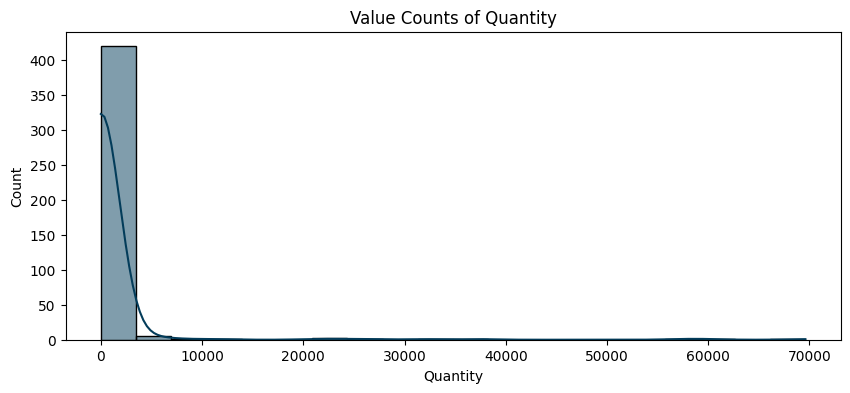

In [20]:
quantity_counts = invoice_df['Quantity'].value_counts()

# Plot the value counts
plt.figure(figsize=(10, 4))
sns.histplot(quantity_counts, bins=20, kde=True, color='#033C5A')
plt.title('Value Counts of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Count')
plt.show()

In [21]:
neg_invoice_df = invoice_df[invoice_df.Quantity<0]
print(f"Number of Negative Invoice records: {neg_invoice_df.shape[0]}")
neg_invoice_df.head()

Number of Negative Invoice records: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [22]:
neg_wo_cancel = neg_invoice_df[neg_invoice_df.InvoiceNo.str[:1] != 'C'].shape[0]
print(f"Number of Negative Invoice records without cancellations: {neg_wo_cancel}")

Number of Negative Invoice records without cancellations: 0


In [23]:
pos_invoice_df = invoice_df[invoice_df.Quantity>0]
print(f"Number of Positive Invoice records: {pos_invoice_df.shape[0]}")
pos_invoice_df.head()

Number of Positive Invoice records: 392732


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [24]:
pos_w_cancel = pos_invoice_df[pos_invoice_df.InvoiceNo.str[:1] == 'C'].shape[0]
print(f"Number of Positive Invoice records with cancellations: {pos_w_cancel}")

Number of Positive Invoice records with cancellations: 0


## Negative Quantity

In [25]:
# Cancellation Rate
cancellation_rate = len(neg_invoice_df) / len(invoice_df) * 100
print(f"Cancellation Rate: {cancellation_rate:.2f}%")

Cancellation Rate: 2.21%


In [26]:
# Impact on Revenue
total_revenue = invoice_df['UnitPrice'].sum()
cancelled_revenue = neg_invoice_df['UnitPrice'].sum()
revenue_impact = (cancelled_revenue / total_revenue) * 100
print(f"Impact on Revenue: {revenue_impact:.2f}%")

Impact on Revenue: 12.02%


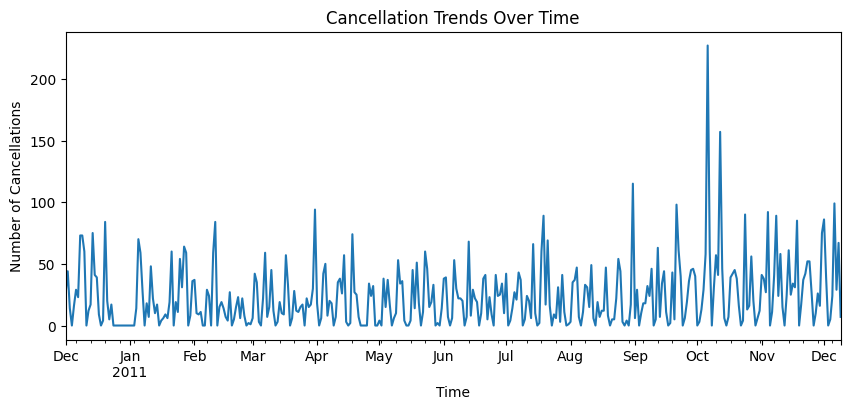

In [27]:
# Cancellation Trend
cancelled_orders = neg_invoice_df.copy()
cancelled_orders.set_index('InvoiceDate', inplace=True)
cancellation_trends = cancelled_orders.resample('D').size()
plt.figure(figsize=(10, 4))
cancellation_trends.plot(title='Cancellation Trends Over Time', ylabel='Number of Cancellations', xlabel='Time')
plt.show()

In [28]:
cancelled_orders['TotalPrice'] = cancelled_orders['UnitPrice'] * cancelled_orders['Quantity'].abs()
customer_cancellations = cancelled_orders.groupby('CustomerID').agg(
    cancel_cnt=('CustomerID', 'count'),
    cancel_amt=('TotalPrice', 'sum')   
).reset_index()
customer_cancellations.head()

,CustomerID,cancel_cnt,cancel_amt
0,12346.0,1,77183.60
1,12352.0,10,960.63
2,12359.0,6,127.05
3,12362.0,8,71.65
4,12365.0,1,320.69


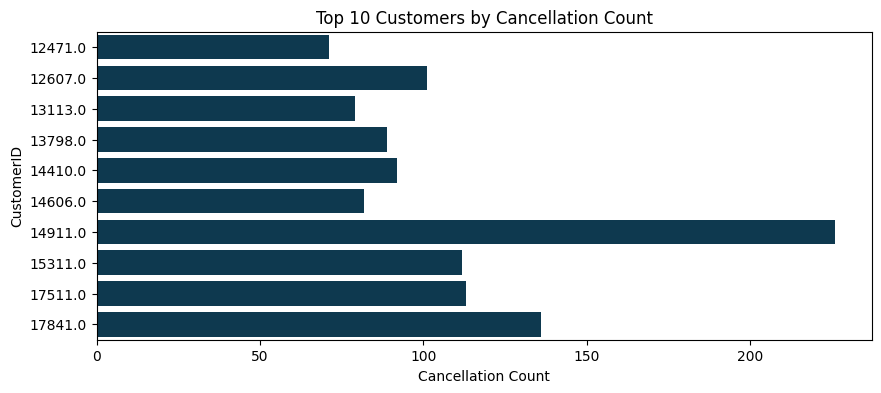

In [29]:
# Customer Analysis
customer_analysis = cancelled_orders.groupby('CustomerID').size().reset_index(name='CancellationCount')
top_customers = customer_analysis.sort_values(by='CancellationCount', ascending=False).head(10)

# Visualize Top 10 Customers with horizontal bar chart
plt.figure(figsize=(10, 4))
sns.barplot(y='CustomerID', x='CancellationCount', data=top_customers, orient='h', color='#033C5A')
plt.title('Top 10 Customers by Cancellation Count')
plt.xlabel('Cancellation Count')
plt.ylabel('CustomerID')
plt.show()

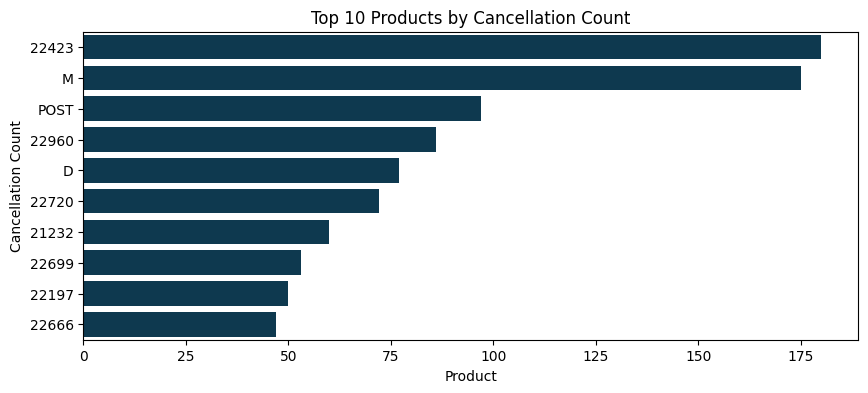

In [30]:
# Product Analysis
product_analysis = cancelled_orders.groupby('StockCode').size().reset_index(name='CancellationCount')
top_products = product_analysis.sort_values(by='CancellationCount', ascending=False).head(10)

plt.figure(figsize=(10, 4))
sns.barplot(y='StockCode', x='CancellationCount', data=top_products, orient='h', color='#033C5A')
plt.title('Top 10 Products by Cancellation Count')
plt.xlabel('Product')
plt.ylabel('Cancellation Count')
plt.show()

In [31]:
neg_invoice_merged_df = neg_invoice_df.merge(
    invoice_df,
    how='inner',
    on=['StockCode','CustomerID','UnitPrice','Country']
)

condition1 = (abs(neg_invoice_merged_df.Quantity_x) == neg_invoice_merged_df.Quantity_y)
condition2 = neg_invoice_merged_df.InvoiceDate_x >= neg_invoice_merged_df.InvoiceDate_y
neg_invoice_merged_df = neg_invoice_merged_df[condition1 & condition2 ]

invoice_match = neg_invoice_merged_df.shape[0]
all_can_invoice = neg_invoice_df.shape[0]

print(f"Percent of cancellation matches: {invoice_match/all_can_invoice*100:.2f}%")

Percent of cancellation matches: 44.56%


In [32]:
cols = ['InvoiceNo_y','StockCode','Description_y','Quantity_y','InvoiceDate_y','UnitPrice','CustomerID','Country']
pos_can_match_df = neg_invoice_merged_df[cols]
pos_can_match_df.columns = neg_invoice_df.columns
pos_can_match_df = pos_can_match_df.drop_duplicates()
pos_can_match_df = pos_can_match_df.sort_values(by=['CustomerID','StockCode','Quantity','InvoiceDate'])
pos_can_match_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4922,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
9897,546869,21914,BLUE HARMONICA IN BOX,12,2011-03-17 16:00:00,1.25,12352.0,Norway
9894,546869,22413,METAL SIGN TAKE IT OR LEAVE IT,6,2011-03-17 16:00:00,2.95,12352.0,Norway
9891,546869,22645,CERAMIC HEART FAIRY CAKE MONEY BANK,12,2011-03-17 16:00:00,1.45,12352.0,Norway
9888,546869,22701,PINK DOG BOWL,6,2011-03-17 16:00:00,2.95,12352.0,Norway


In [33]:
# Retrieve corresponding orders of cancellations, if available

rows_to_drop = pd.DataFrame(columns=neg_invoice_df.columns)

for neg_idx, neg_row in neg_invoice_df.iterrows():

    rows_to_drop.loc[len(rows_to_drop)] = neg_row

    cond1 = pos_can_match_df.CustomerID == neg_row.CustomerID
    cond2 = pos_can_match_df.StockCode == neg_row.StockCode
    cond3 = pos_can_match_df.Quantity == abs(neg_row.Quantity)
    cond4 = pos_can_match_df.InvoiceDate <= neg_row.InvoiceDate

    temp = pos_can_match_df[cond1 & cond2 & cond3 & cond4]

    if temp.shape[0]>0:
        rows_to_drop.loc[len(rows_to_drop)] = temp.iloc[0]
        pos_can_match_df.drop(temp.index[0], inplace=True)

print(f"Number of transactions to remove: {rows_to_drop.shape[0]}")

Number of transactions to remove: 11643


In [34]:
# Remove cancellations and corresponding orders

fin_invoice_df = pd.merge(
    invoice_df, rows_to_drop,
    how='outer',
    indicator=True
).query("_merge != 'both'").drop('_merge', axis=1).reset_index(drop=True)

if (invoice_df.shape[0] - (fin_invoice_df.shape[0] + rows_to_drop.shape[0])):
    print(f"Missed records that are not removed from the original data: {missed_records}")
else:
    print("All records are removed from the original data successfully")

All records are removed from the original data successfully


## Price

In [35]:
print(f"Records with negative quantity -> {fin_invoice_df[fin_invoice_df.Quantity<0].shape[0]}")
print(f"Records with zero quantity -> {fin_invoice_df[fin_invoice_df.Quantity==0].shape[0]}")
print(f"Records with negative unit price -> {fin_invoice_df[fin_invoice_df.UnitPrice<0].shape[0]}")
print(f"Records with zero unit price -> {fin_invoice_df[fin_invoice_df.UnitPrice==0].shape[0]}")

Records with negative quantity -> 0
Records with zero quantity -> 0
Records with negative unit price -> 0
Records with zero unit price -> 40


In [36]:
# Remove records with zero unit price

fin_invoice_df = fin_invoice_df[fin_invoice_df.UnitPrice>0]
print(f"Records with zero unit price -> {fin_invoice_df[fin_invoice_df.UnitPrice==0].shape[0]}")

Records with zero unit price -> 0


## Basket Price

In [37]:
# Create TotalPrice feature

fin_invoice_df['TotalPrice'] = fin_invoice_df['UnitPrice'] * fin_invoice_df['Quantity']
fin_invoice_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [38]:
temp = fin_invoice_df.copy(deep=True)
temp['InvoiceDate'] = fin_invoice_df['InvoiceDate'].dt.strftime('%Y-%m-%d')
rollup_invoice_df = temp.groupby(
    ['CustomerID','InvoiceNo','InvoiceDate','Country']
).agg(BasketPrice=('TotalPrice', 'sum')).reset_index()
rollup_invoice_df.head()

,CustomerID,InvoiceNo,InvoiceDate,Country,BasketPrice
0,12347.0,537626,2010-12-07,Iceland,711.79
1,12347.0,542237,2011-01-26,Iceland,475.39
2,12347.0,549222,2011-04-07,Iceland,636.25
3,12347.0,556201,2011-06-09,Iceland,382.52
4,12347.0,562032,2011-08-02,Iceland,584.91


## Time Slots

In [39]:
time_slot = fin_invoice_df[['CustomerID','InvoiceNo','InvoiceDate']]
time_slot.drop_duplicates(inplace=True)
time_slot.head()

,CustomerID,InvoiceNo,InvoiceDate
0,17850.0,536365,2010-12-01 08:26:00
7,17850.0,536366,2010-12-01 08:28:00
8,13047.0,536367,2010-12-01 08:34:00
20,13047.0,536368,2010-12-01 08:34:00
24,13047.0,536369,2010-12-01 08:35:00


In [40]:
# Define time slots
morning_slot = (6, 12)
afternoon_slot = (12, 18)
evening_slot = (18, 24)

# Function to categorize time slots
def categorize_time_slot(hour):
    if morning_slot[0] <= hour < morning_slot[1]:
        return 'morning'
    elif afternoon_slot[0] <= hour < afternoon_slot[1]:
        return 'afternoon'
    elif evening_slot[0] <= hour < evening_slot[1]:
        return 'evening'
    else:
        return 'night'

In [41]:
# Add a new column for time slot
time_slot['time_slot'] = time_slot['InvoiceDate'].dt.hour.apply(categorize_time_slot)
time_slot.head()

,CustomerID,InvoiceNo,InvoiceDate,time_slot
0,17850.0,536365,2010-12-01 08:26:00,morning
7,17850.0,536366,2010-12-01 08:28:00,morning
8,13047.0,536367,2010-12-01 08:34:00,morning
20,13047.0,536368,2010-12-01 08:34:00,morning
24,13047.0,536369,2010-12-01 08:35:00,morning


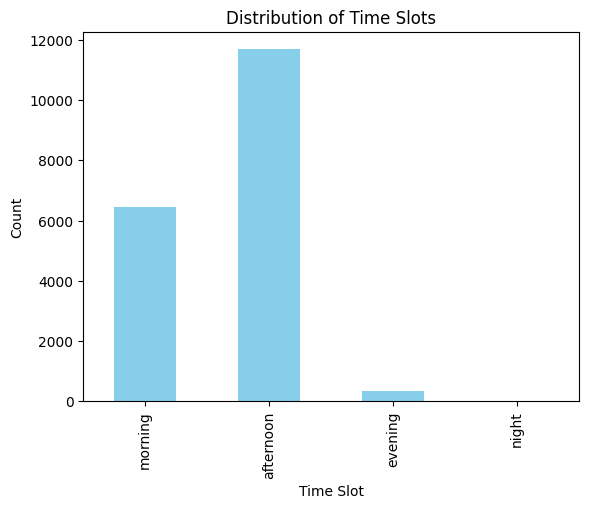

In [42]:
# Create a bar plot of time_slot distribution
time_slot_counts = time_slot['time_slot'].value_counts()
time_slot_counts = time_slot_counts.reindex(['morning', 'afternoon', 'evening', 'night'])  # Sort the time slots

time_slot_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Time Slots')
plt.xlabel('Time Slot')
plt.ylabel('Count')
plt.show()

In [43]:
# Pivot the DataFrame to have time slots as columns
time_slot_pv = time_slot.pivot_table(index='CustomerID', columns='time_slot', aggfunc='size', fill_value=0).reset_index()
time_slot_pv.rename_axis(None, axis=1, inplace=True)

# Display the result
time_slot_pv.head()

,CustomerID,afternoon,evening,morning
0,12347.0,5,0,2
1,12348.0,1,1,2
2,12349.0,0,0,1
3,12350.0,1,0,0
4,12352.0,8,0,0


# Product Categories

In [45]:
desc = fin_invoice_df['Description']

cleaned_desc = []
for obs in desc:
    cleaned_desc.extend(hf.clean_text(obs))
    

fin_invoice_df['clean_desc'] = cleaned_desc 
unq_desc = list(set(cleaned_desc))

In [46]:
# add argument top=100 for top 100 word vocab
freq, vocab, word_to_id = hf.create_word_mappings_from_corpus(unq_desc)

In [47]:
# adding 6 more dimensions for price related features
embeddings = hf.create_embeddings(word_to_id, unq_desc, len(vocab)+6)

In [48]:
price_arr = np.zeros((len(unq_desc), 6))  
threshold = [0, 1, 2, 3, 5, 10]

for i, prod in enumerate(unq_desc):
    mean_prod_price = fin_invoice_df[ fin_invoice_df['clean_desc'] == prod]['UnitPrice'].mean()
    j = 0
    while mean_prod_price > threshold[j]:
        j+=1
        if j == len(threshold): 
            break
            
    price_arr[i][j-1] = 1

In [49]:
for i in range(price_arr.shape[1]):
    embeddings[:,len(vocab)+i] = price_arr[:,i]

## Clustering Products

In [50]:
# KMeans on CPU

for n_clusters in range(3,11):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(embeddings)
    clusters = kmeans.predict(embeddings)
    globals()[f"n_{n_clusters}"] = clusters
    silhouette_avg = silhouette_score(embeddings, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", round(silhouette_avg,2))

For n_clusters = 3 The average silhouette_score is : 0.6
For n_clusters = 4 The average silhouette_score is : 0.75
For n_clusters = 5 The average silhouette_score is : 0.87
For n_clusters = 6 The average silhouette_score is : 0.92
For n_clusters = 7 The average silhouette_score is : 0.93
For n_clusters = 8 The average silhouette_score is : 0.94
For n_clusters = 9 The average silhouette_score is : 0.94
For n_clusters = 10 The average silhouette_score is : 0.95


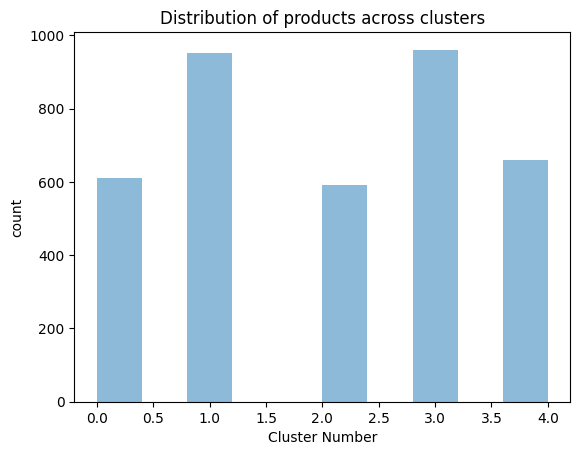

In [51]:
plt.hist(n_5, alpha=0.5)
plt.title('Distribution of products across clusters')
plt.xlabel('Cluster Number')
plt.ylabel('count')

plt.show()

In [52]:
product_cluster = pd.DataFrame({
    'clean_desc': unq_desc,
    'cluster': n_5
})
product_cluster.head()

,clean_desc,cluster
0,pink scottie dog w flower pattern,4
1,summer fun design shower cap,1
2,decoration wobbly chicken metal,3
3,black candelabra t light holder,3
4,purple gemstone necklace 45cm,0


In [53]:
product_cluster['cluster'].value_counts() 

3    961
1    953
4    661
0    612
2    593
Name: cluster, dtype: int64

In [54]:
fin_invoice_df = fin_invoice_df.merge(product_cluster, on=['clean_desc'])
fin_invoice_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,clean_desc,cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.3,white hanging heart t light holder,4
1,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:02:00,2.55,17850.0,United Kingdom,15.3,white hanging heart t light holder,4
2,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:32:00,2.55,17850.0,United Kingdom,15.3,white hanging heart t light holder,4
3,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,2010-12-01 10:19:00,2.55,17511.0,United Kingdom,163.2,white hanging heart t light holder,4
4,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2010-12-01 10:39:00,2.55,13408.0,United Kingdom,81.6,white hanging heart t light holder,4


In [55]:
fin_invoice_df['cluster'].value_counts()

3    111566
1     90035
4     80151
2     56523
0     51646
Name: cluster, dtype: int64

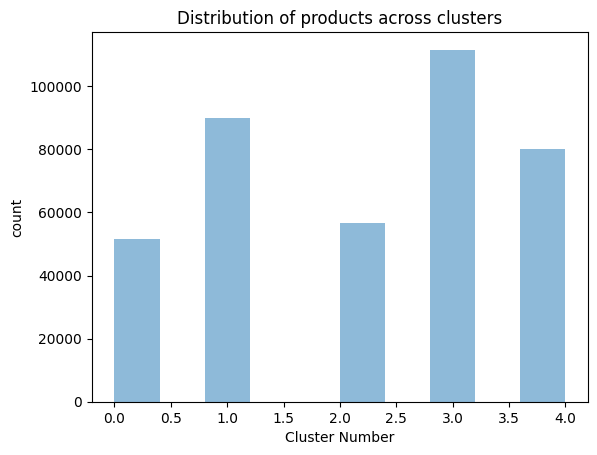

In [56]:
plt.hist(fin_invoice_df['cluster'], alpha=0.5)
plt.title('Distribution of products across clusters')
plt.xlabel('Cluster Number')
plt.ylabel('count')

plt.show()

## Make word Clouds

In [57]:
fin_invoice_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,clean_desc,cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.3,white hanging heart t light holder,4
1,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:02:00,2.55,17850.0,United Kingdom,15.3,white hanging heart t light holder,4
2,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:32:00,2.55,17850.0,United Kingdom,15.3,white hanging heart t light holder,4
3,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,2010-12-01 10:19:00,2.55,17511.0,United Kingdom,163.2,white hanging heart t light holder,4
4,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2010-12-01 10:39:00,2.55,13408.0,United Kingdom,81.6,white hanging heart t light holder,4


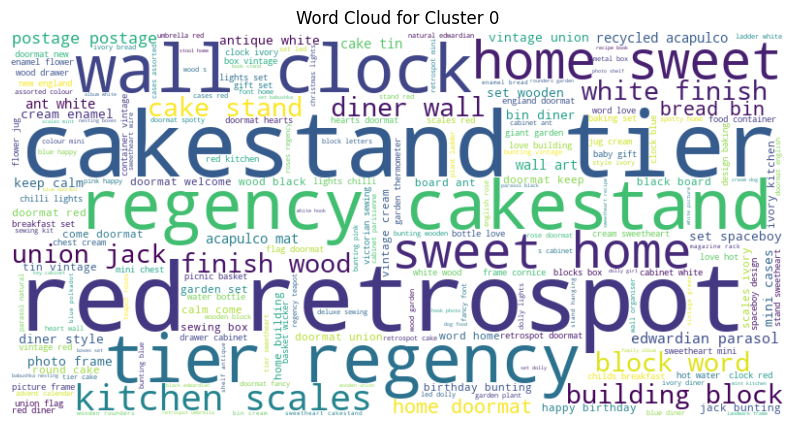

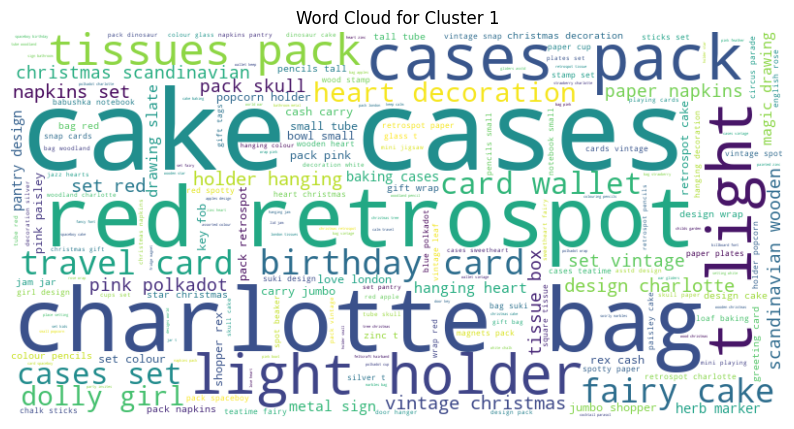

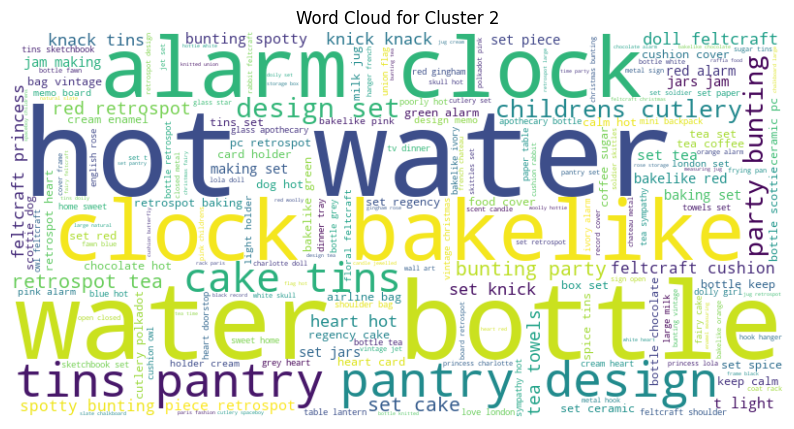

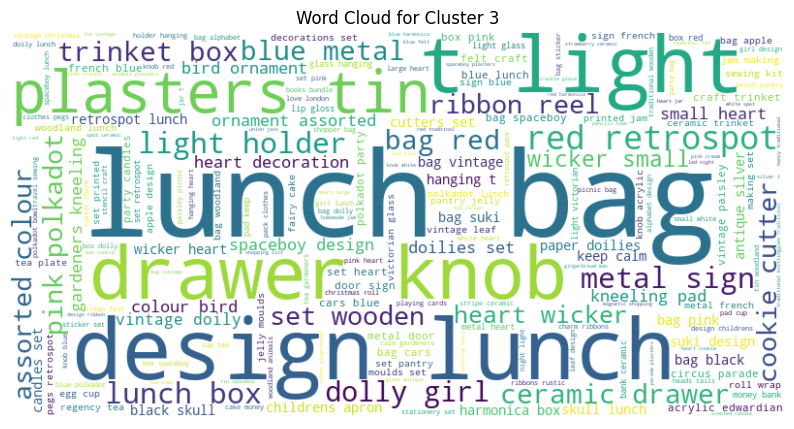

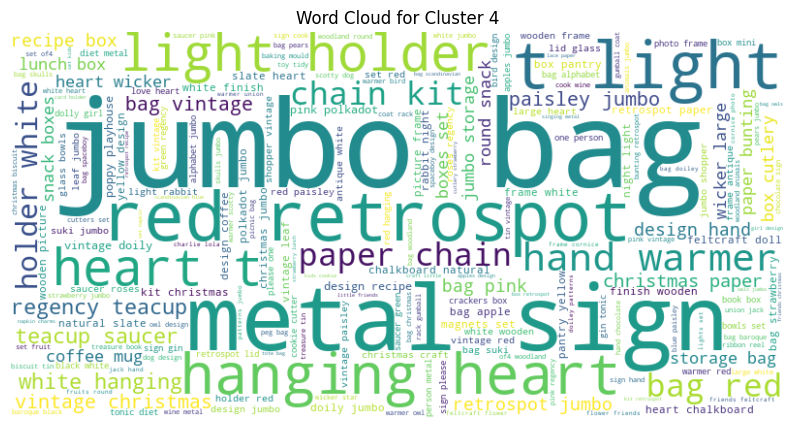

In [58]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'your_dataset.csv' is your dataset file
df = fin_invoice_df.copy()

# Function to generate word cloud for a specific cluster
def generate_wordcloud(cluster):
    # Filter the DataFrame for the specified cluster
    cluster_data = df[df['cluster'] == cluster]

    # Combine all descriptions for the cluster into a single string
    text = ' '.join(cluster_data['clean_desc'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot the WordCloud image
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.show()

clusters_to_visualize = set(df['cluster'])

# Generate word cloud for each specified cluster
for cluster in clusters_to_visualize:
    generate_wordcloud(cluster)


# Customer Categories

In [59]:
temp = fin_invoice_df.copy(deep=True)

In [60]:
for i in range(5):
    col = 'C{}'.format(i)        
    df_temp = temp[temp['cluster'] == i]
    price_temp = df_temp['TotalPrice']
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    temp.loc[:, col] = price_temp
    temp[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
temp[['CustomerID', 'InvoiceNo', 'Description', 'cluster', 'C0', 'C1', 'C2', 'C3','C4']][:5]

,CustomerID,InvoiceNo,Description,cluster,C0,C1,C2,C3,C4
0,17850.0,536365,WHITE HANGING HEART T-LIGHT HOLDER,4,0.0,0.0,0.0,0.0,15.3
1,17850.0,536373,WHITE HANGING HEART T-LIGHT HOLDER,4,0.0,0.0,0.0,0.0,15.3
2,17850.0,536375,WHITE HANGING HEART T-LIGHT HOLDER,4,0.0,0.0,0.0,0.0,15.3
3,17511.0,536390,WHITE HANGING HEART T-LIGHT HOLDER,4,0.0,0.0,0.0,0.0,163.2
4,13408.0,536394,WHITE HANGING HEART T-LIGHT HOLDER,4,0.0,0.0,0.0,0.0,81.6


In [61]:
customer_df = temp.groupby(
    ['CustomerID','InvoiceNo','InvoiceDate','Country']
).agg(
    TransCount=('InvoiceNo', 'count'),
    C0 = ('C0','sum'),
    C1 = ('C1','sum'),
    C2 = ('C2','sum'),
    C3 = ('C3','sum'),
    C4 = ('C4','sum'),
    TotalPrice = ('TotalPrice','sum')
).reset_index()
customer_df.head()

,CustomerID,InvoiceNo,InvoiceDate,Country,TransCount,C0,C1,C2,C3,C4,TotalPrice
0,12347.0,537626,2010-12-07 14:57:00,Iceland,31,124.44,40.80,293.35,169.8,83.40,711.79
1,12347.0,542237,2011-01-26 14:30:00,Iceland,29,38.25,84.34,169.20,130.5,53.10,475.39
2,12347.0,549222,2011-04-07 10:43:00,Iceland,24,38.25,81.00,115.00,330.9,71.10,636.25
3,12347.0,556201,2011-06-09 13:01:00,Iceland,18,19.90,41.40,168.76,74.4,78.06,382.52
4,12347.0,562032,2011-08-02 08:48:00,Iceland,22,136.05,61.30,158.16,109.7,119.70,584.91


In [62]:
transactions_per_user=customer_df.groupby(by=['CustomerID'])['TotalPrice'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'C{}'.format(i)
    transactions_per_user.loc[:,col] = customer_df.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
transactions_per_user.columns = ['CustomerID','Count','Min_BP','Max_BP','Mean_BP','Total_BP','C0','C1','C2','C3','C4']
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,Count,Min_BP,Max_BP,Mean_BP,Total_BP,C0,C1,C2,C3,C4
0,12347.0,7,224.82,1294.32,615.714286,4310.0,12.041531,11.640835,29.540371,25.972158,20.805104
1,12348.0,4,227.44,892.80,449.310000,1797.24,20.030714,38.016069,0.0,41.953217,0.0
2,12349.0,1,1757.55,1757.55,1757.550000,1757.55,46.02145,4.513101,10.713778,26.506216,12.245455
3,12350.0,1,334.40,334.40,334.400000,334.4,11.961722,16.895933,0.0,43.241627,27.900718
4,12352.0,8,19.80,840.30,298.213750,2385.71,64.322571,1.299404,14.601523,15.705178,4.071325


## Customer order Combinations

In [63]:
current_date = customer_df['InvoiceDate'].max()
recency_df = customer_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days
}).reset_index()
recency_df.columns = ['CustomerID', 'Recency']
recency_df.head()

,CustomerID,Recency
0,12347.0,1
1,12348.0,74
2,12349.0,18
3,12350.0,309
4,12352.0,35


In [64]:
# Merging

transactions_per_user = transactions_per_user.merge(recency_df)
transactions_per_user.head()

,CustomerID,Count,Min_BP,Max_BP,Mean_BP,Total_BP,C0,C1,C2,C3,C4,Recency
0,12347.0,7,224.82,1294.32,615.714286,4310.0,12.041531,11.640835,29.540371,25.972158,20.805104,1
1,12348.0,4,227.44,892.80,449.310000,1797.24,20.030714,38.016069,0.0,41.953217,0.0,74
2,12349.0,1,1757.55,1757.55,1757.550000,1757.55,46.02145,4.513101,10.713778,26.506216,12.245455,18
3,12350.0,1,334.40,334.40,334.400000,334.4,11.961722,16.895933,0.0,43.241627,27.900718,309
4,12352.0,8,19.80,840.30,298.213750,2385.71,64.322571,1.299404,14.601523,15.705178,4.071325,35


In [65]:
customer_cancellations.head()

,CustomerID,cancel_cnt,cancel_amt
0,12346.0,1,77183.60
1,12352.0,10,960.63
2,12359.0,6,127.05
3,12362.0,8,71.65
4,12365.0,1,320.69


In [66]:
rfm_df = transactions_per_user.merge(customer_cancellations, how='left', on=['CustomerID'])
rfm_df.fillna('0', inplace=True)
rfm_df['Total_BP'] = pd.to_numeric(rfm_df['Total_BP'])
rfm_df['cancel_cnt'] = pd.to_numeric(rfm_df['cancel_cnt'])
rfm_df['cancel_amt'] = pd.to_numeric(rfm_df['cancel_amt'])
rfm_df['Revenue_Lost_Ratio'] = np.round(rfm_df['cancel_amt'] / rfm_df['Total_BP'], 2)
rfm_df.head(n=10)

,CustomerID,Count,Min_BP,Max_BP,Mean_BP,Total_BP,C0,C1,C2,C3,C4,Recency,cancel_cnt,cancel_amt,Revenue_Lost_Ratio
0,12347.0,7,224.82,1294.32,615.714286,4310.00,12.041531,11.640835,29.540371,25.972158,20.805104,1,0.0,0.00,0.0
1,12348.0,4,227.44,892.80,449.310000,1797.24,20.030714,38.016069,0.0,41.953217,0.0,74,0.0,0.00,0.0
2,12349.0,1,1757.55,1757.55,1757.550000,1757.55,46.02145,4.513101,10.713778,26.506216,12.245455,18,0.0,0.00,0.0
3,12350.0,1,334.40,334.40,334.400000,334.40,11.961722,16.895933,0.0,43.241627,27.900718,309,0.0,0.00,0.0
4,12352.0,8,19.80,840.30,298.213750,2385.71,64.322571,1.299404,14.601523,15.705178,4.071325,35,10.0,960.63,0.4
5,12353.0,1,89.00,89.00,89.000000,89.00,67.078652,0.0,0.0,13.033708,19.88764,203,0.0,0.00,0.0
6,12354.0,1,1079.40,1079.40,1079.400000,1079.40,23.346304,14.950899,19.70076,31.17658,10.825459,231,0.0,0.00,0.0
7,12355.0,1,459.40,459.40,459.400000,459.40,9.882455,0.0,25.272094,53.286896,11.558555,213,0.0,0.00,0.0
8,12356.0,3,58.35,2271.62,937.143333,2811.43,37.94617,14.147605,7.256094,28.062232,12.5879,22,0.0,0.00,0.0
9,12357.0,1,6207.67,6207.67,6207.670000,6207.67,33.39981,5.089832,28.350089,18.475531,14.684737,32,0.0,0.00,0.0


In [67]:
# Merging for time slots

rfm_df = rfm_df.merge(time_slot_pv)
rfm_df.head()

,CustomerID,Count,Min_BP,Max_BP,Mean_BP,Total_BP,C0,C1,C2,C3,C4,Recency,cancel_cnt,cancel_amt,Revenue_Lost_Ratio,afternoon,evening,morning
0,12347.0,7,224.82,1294.32,615.714286,4310.00,12.041531,11.640835,29.540371,25.972158,20.805104,1,0.0,0.00,0.0,5,0,2
1,12348.0,4,227.44,892.80,449.310000,1797.24,20.030714,38.016069,0.0,41.953217,0.0,74,0.0,0.00,0.0,1,1,2
2,12349.0,1,1757.55,1757.55,1757.550000,1757.55,46.02145,4.513101,10.713778,26.506216,12.245455,18,0.0,0.00,0.0,0,0,1
3,12350.0,1,334.40,334.40,334.400000,334.40,11.961722,16.895933,0.0,43.241627,27.900718,309,0.0,0.00,0.0,1,0,0
4,12352.0,8,19.80,840.30,298.213750,2385.71,64.322571,1.299404,14.601523,15.705178,4.071325,35,10.0,960.63,0.4,8,0,0


# PCA

Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

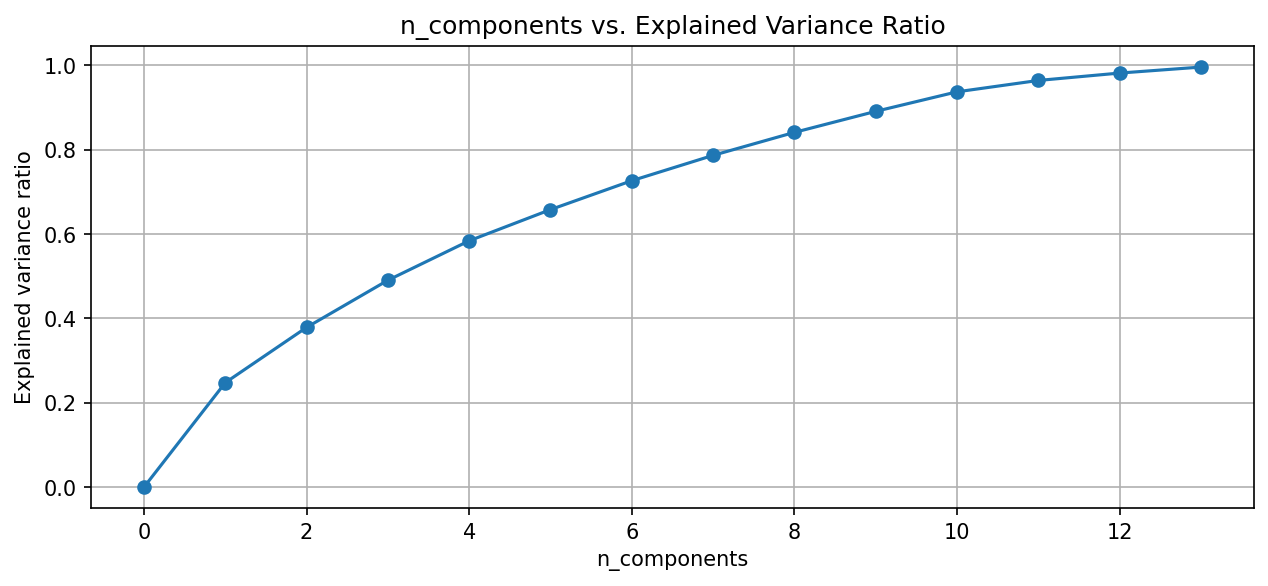

In [68]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

feature_names = list(rfm_df.columns)
feature_names.remove('CustomerID')

data = rfm_df[feature_names]

scaled_df = std_scaler.fit_transform(data)

from sklearn.decomposition import PCA

var_ratio = []
nums = np.arange(14)
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(scaled_df)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4),dpi=150)
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

For n_clusters = 3 The average silhouette_score is : 0.83
For n_clusters = 4 The average silhouette_score is : 0.14
For n_clusters = 5 The average silhouette_score is : 0.16
For n_clusters = 6 The average silhouette_score is : 0.13
For n_clusters = 7 The average silhouette_score is : 0.14
For n_clusters = 8 The average silhouette_score is : 0.14
For n_clusters = 9 The average silhouette_score is : 0.15


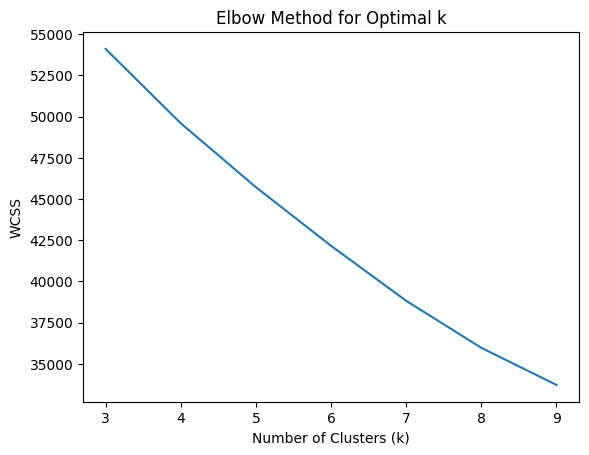

Give best Cluster:    7


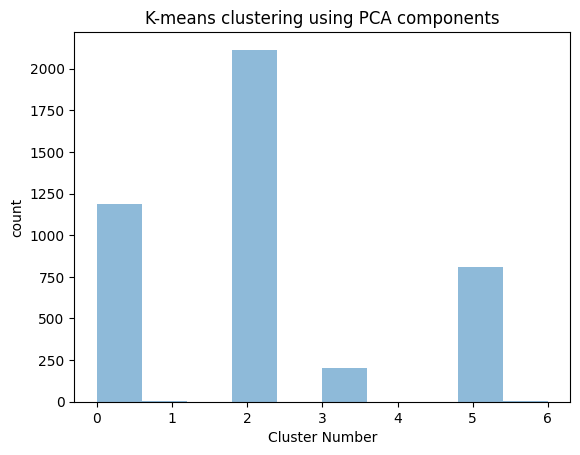

In [71]:
pca = PCA(n_components=12)
pca.fit(scaled_df)
X_scaled = pca.transform(scaled_df)
max_clusters = 10

wcss = []
silhouette_scores = []
all_clusters = []
plot = 1

for i in range(3, max_clusters):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)

    wcss.append(kmeans.inertia_)
    clusters = kmeans.predict(X_scaled)
    all_clusters.append(clusters)
    silhouette_avg = silhouette_score(X_scaled, clusters)
    silhouette_scores.append(round(silhouette_avg, 2))

    print("For n_clusters =", i, "The average silhouette_score is :", round(silhouette_avg,2))

if plot: 
    # Plot the elbow graph to find the optimal number of clusters
    plt.plot(range(3, max_clusters), wcss)
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.show()

clusters = int(input("Give best Cluster:    "))
plt.hist(all_clusters[clusters-3], alpha=0.5)
plt.title("K-means clustering using PCA components")
plt.xlabel('Cluster Number')
plt.ylabel('count')
plt.show()

## Clustering on Customers

### All Features

For n_clusters = 3 The average silhouette_score is : 0.14
For n_clusters = 4 The average silhouette_score is : 0.14
For n_clusters = 5 The average silhouette_score is : 0.15
For n_clusters = 6 The average silhouette_score is : 0.12
For n_clusters = 7 The average silhouette_score is : 0.13
For n_clusters = 8 The average silhouette_score is : 0.14
For n_clusters = 9 The average silhouette_score is : 0.14


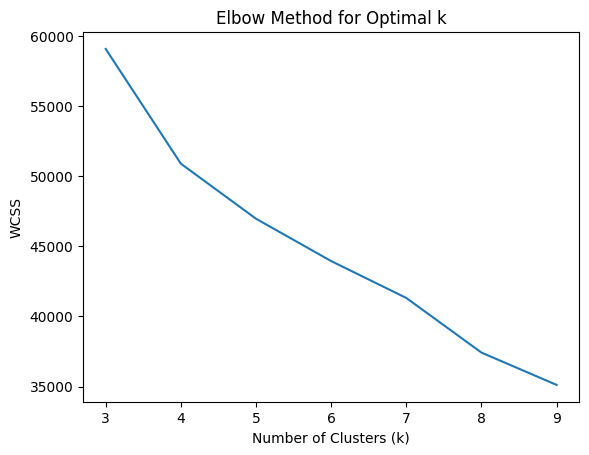

Give best Cluster:    5


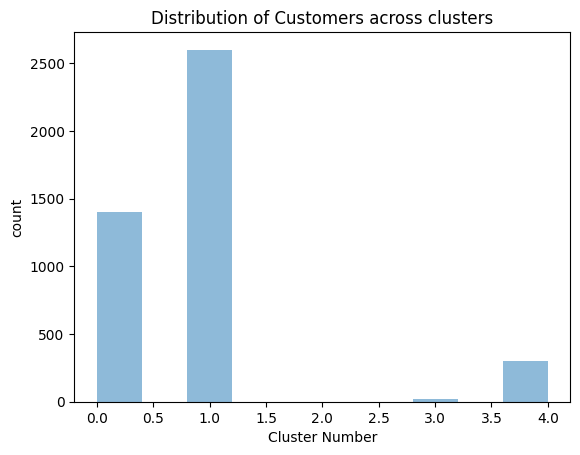

In [72]:
feature_names = list(rfm_df.columns)
feature_names.remove('CustomerID')
title = 'Distribution of Customers across clusters'
all_feature_clusters = hf.get_kmeans(rfm_df, feature_names, 10, title, plot = True )

### Basket Price

For n_clusters = 3 The average silhouette_score is : 0.17
For n_clusters = 4 The average silhouette_score is : 0.15
For n_clusters = 5 The average silhouette_score is : 0.15
For n_clusters = 6 The average silhouette_score is : 0.16
For n_clusters = 7 The average silhouette_score is : 0.16
For n_clusters = 8 The average silhouette_score is : 0.18
For n_clusters = 9 The average silhouette_score is : 0.2


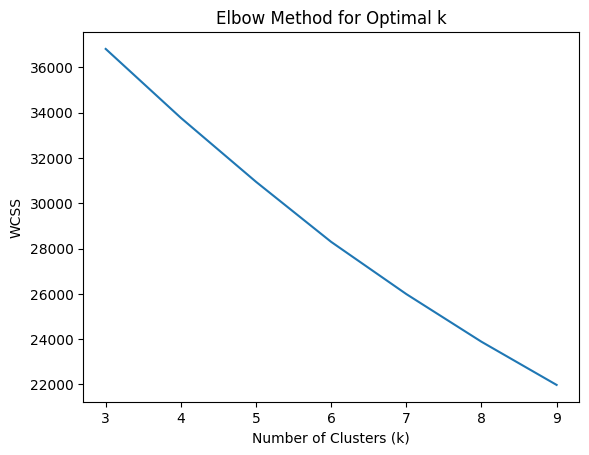

Give best Cluster:    7


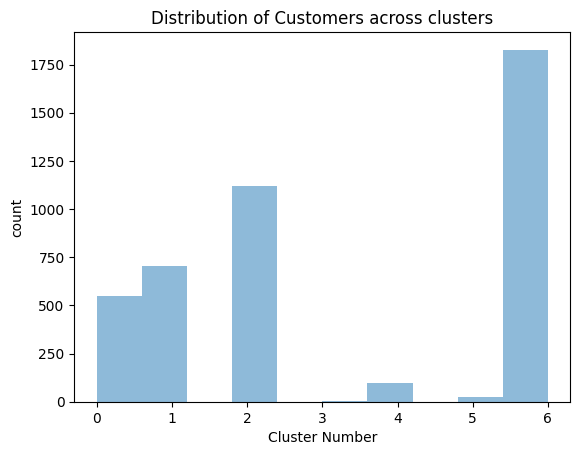

In [73]:
feature_names = ['Count','Min_BP','Max_BP','Mean_BP','Total_BP','C0','C1','C2','C3','C4','Recency']
title = 'Distribution of Customers across clusters'
basket_clusters = hf.get_kmeans(rfm_df, feature_names, 10, title, plot = True )

### Time

For n_clusters = 3 The average silhouette_score is : 0.81
For n_clusters = 4 The average silhouette_score is : 0.69
For n_clusters = 5 The average silhouette_score is : 0.71
For n_clusters = 6 The average silhouette_score is : 0.61
For n_clusters = 7 The average silhouette_score is : 0.65
For n_clusters = 8 The average silhouette_score is : 0.56
For n_clusters = 9 The average silhouette_score is : 0.55


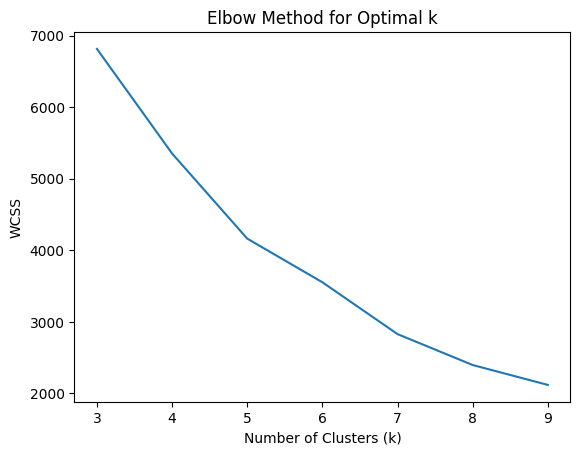

Give best Cluster:    5


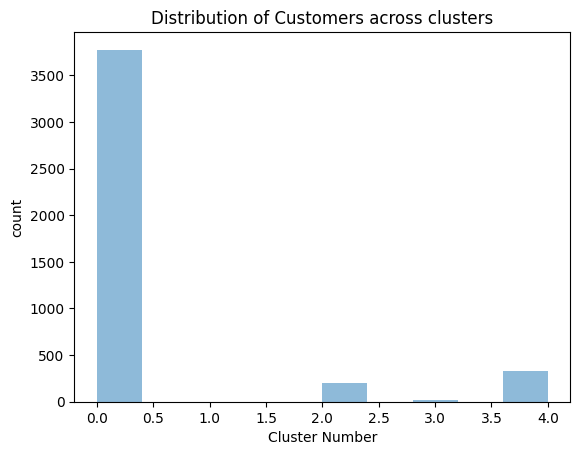

In [74]:
feature_names = ['afternoon','evening','morning']
title = 'Distribution of Customers across clusters'
time_clusters = hf.get_kmeans(rfm_df, feature_names, 10, title, plot = True )

### VarianceThreshold

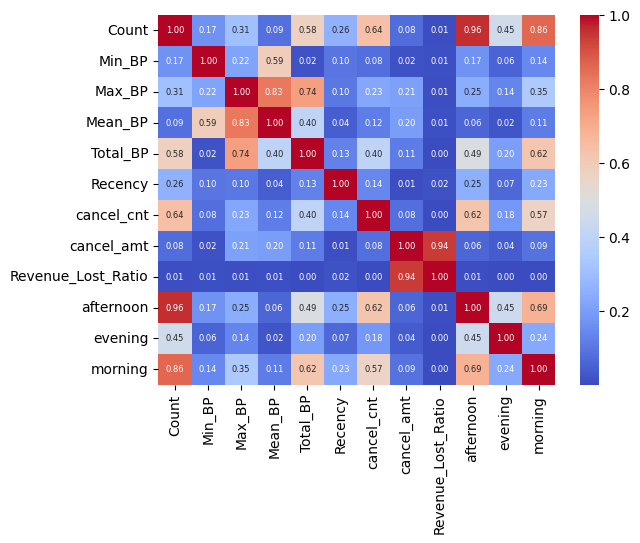


Selected features: ['Count', 'Min_BP', 'Max_BP', 'C0', 'C1', 'C2', 'C3', 'C4', 'Recency', 'cancel_cnt', 'cancel_amt', 'evening']


In [75]:
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.feature_selection import SelectKBest, mutual_info_classif

feature_names = list(rfm_df.columns)
feature_names.remove('CustomerID')

X = rfm_df[feature_names]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
correlation_matrix = X.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.7)]
X_selected = X.drop(columns=to_drop)
selected_feature_names = [feature_names[i] for i in range(len(feature_names)) if feature_names[i] not in to_drop]

annot_kws = {'size': 6}
sns.heatmap(correlation_matrix,  annot=True, cmap='coolwarm', fmt='.2f',annot_kws=annot_kws)
plt.show()

print("\nSelected features:", selected_feature_names)

For n_clusters = 3 The average silhouette_score is : 0.11
For n_clusters = 4 The average silhouette_score is : 0.14
For n_clusters = 5 The average silhouette_score is : 0.14
For n_clusters = 6 The average silhouette_score is : 0.15
For n_clusters = 7 The average silhouette_score is : 0.15
For n_clusters = 8 The average silhouette_score is : 0.16
For n_clusters = 9 The average silhouette_score is : 0.17


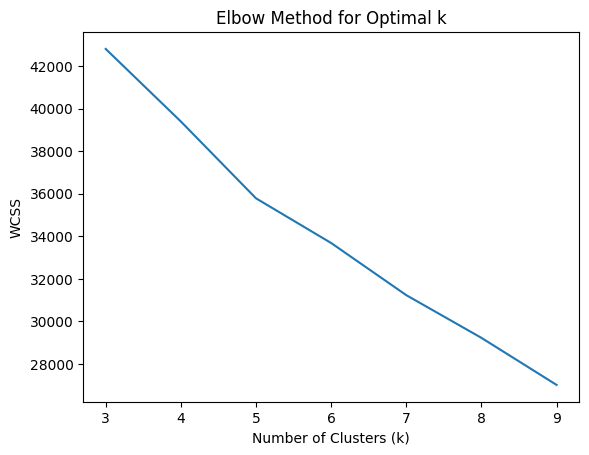

Give best Cluster:    5


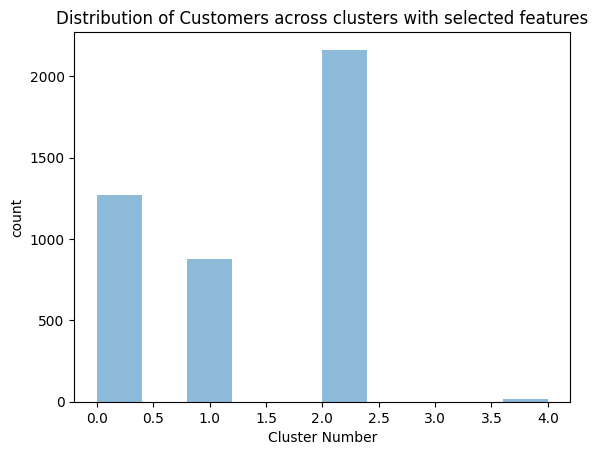

array([2, 0, 1, ..., 2, 2, 0], dtype=int32)

In [76]:
title = 'Distribution of Customers across clusters with selected features'
hf.get_kmeans(rfm_df, selected_feature_names, 10, title, plot = True )

### Finalized Clustering Features

In [77]:
customer_clusters = pd.DataFrame({
    'CustomerID': rfm_df['CustomerID'],
    'cluster': basket_clusters
})

final_data = rfm_df.merge(customer_clusters)
final_data.head()

,CustomerID,Count,Min_BP,Max_BP,Mean_BP,Total_BP,C0,C1,C2,C3,C4,Recency,cancel_cnt,cancel_amt,Revenue_Lost_Ratio,afternoon,evening,morning,cluster
0,12347.0,7,224.82,1294.32,615.714286,4310.00,12.041531,11.640835,29.540371,25.972158,20.805104,1,0.0,0.00,0.0,5,0,2,6
1,12348.0,4,227.44,892.80,449.310000,1797.24,20.030714,38.016069,0.0,41.953217,0.0,74,0.0,0.00,0.0,1,1,2,2
2,12349.0,1,1757.55,1757.55,1757.550000,1757.55,46.02145,4.513101,10.713778,26.506216,12.245455,18,0.0,0.00,0.0,0,0,1,4
3,12350.0,1,334.40,334.40,334.400000,334.40,11.961722,16.895933,0.0,43.241627,27.900718,309,0.0,0.00,0.0,1,0,0,2
4,12352.0,8,19.80,840.30,298.213750,2385.71,64.322571,1.299404,14.601523,15.705178,4.071325,35,10.0,960.63,0.4,8,0,0,1


# Classification on Customers

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Split the data into features (X) and target variable (y)
X = final_data.drop(columns=['CustomerID','cluster'])
y = final_data.drop(columns=['CustomerID'])['cluster']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## KNN

In [79]:
from sklearn.neighbors import KNeighborsClassifier


# Set up the parameter grid for grid search
param_grid = {'n_neighbors': range(1,50,5)}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Create the grid search object
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the KNN classifier with the best parameters
best_knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
best_knn.fit(X_train, y_train)

# Make predictions on the train set
y_train_pred = best_knn.predict(X_train)

# Make predictions on the test set
y_pred = best_knn.predict(X_test)

# Evaluate the performance
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Best Parameters: {best_params}')
print(f'Training Accuracy with Best Parameters: {train_accuracy*100:.2f}%')
print(f'Validation Accuracy with Best Parameters: {test_accuracy*100:.2f}%')
print('Classification Report:\n', classification_rep)

Best Parameters: {'n_neighbors': 11}
Training Accuracy with Best Parameters: 70.21%
Validation Accuracy with Best Parameters: 67.90%
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.27      0.37        86
           1       0.74      0.56      0.63       151
           2       0.62      0.59      0.60       206
           3       0.00      0.00      0.00         2
           4       0.83      0.90      0.86        21
           5       0.75      0.60      0.67         5
           6       0.69      0.86      0.76       395

    accuracy                           0.68       866
   macro avg       0.60      0.54      0.56       866
weighted avg       0.67      0.68      0.66       866



## SVC

In [80]:
from sklearn.svm import LinearSVC


# Set up the parameter grid for grid search
param_grid = {'C': [0.1, 1, 10, 100]}

# Initialize the LinearSVC classifier
svc = LinearSVC()

# Create the grid search object
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the LinearSVC classifier with the best parameters
best_svc = LinearSVC(C=best_params['C'])
best_svc.fit(X_train, y_train)

# Make predictions on the train set
y_train_pred = best_svc.predict(X_train)

# Make predictions on the test set
y_pred = best_svc.predict(X_test)


# Evaluate the performance
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Best Parameters: {best_params}')
print(f'Training Accuracy with Best Parameters: {train_accuracy*100:.2f}%')
print(f'Validation Accuracy with Best Parameters: {test_accuracy*100:.2f}%')
print('Classification Report:\n', classification_rep)

Best Parameters: {'C': 1}
Training Accuracy with Best Parameters: 66.48%
Validation Accuracy with Best Parameters: 63.74%
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.81      0.85        86
           1       0.98      0.84      0.91       151
           2       0.41      1.00      0.58       206
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00         5
           6       0.96      0.38      0.54       395

    accuracy                           0.64       866
   macro avg       0.46      0.43      0.41       866
weighted avg       0.80      0.64      0.63       866

